In [86]:
import nfl_data_py as nfl
import pandas as pd
import os
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox
from matplotlib.offsetbox import OffsetImage

from PIL import Image
import numpy as np
from io import BytesIO
import requests
# ML Libraryies
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import hvplot.pandas
import plotly.express as px

# Graphing 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure

In [3]:
# Import Data

weekly_nfl = nfl.import_weekly_data([2023])
weekly_nfl.dtypes

Downcasting floats.


player_id                       object
player_name                     object
player_display_name             object
position                        object
position_group                  object
headshot_url                    object
recent_team                     object
season                           int32
week                             int32
season_type                     object
opponent_team                   object
completions                      int32
attempts                         int32
passing_yards                  float32
passing_tds                      int32
interceptions                  float32
sacks                          float32
sack_yards                     float32
sack_fumbles                     int32
sack_fumbles_lost                int32
passing_air_yards              float32
passing_yards_after_catch      float32
passing_first_downs            float32
passing_epa                    float32
passing_2pt_conversions          int32
pacr                     

In [22]:
# create df for defense
d_columns = ['opponent_team', 'rushing_epa', 'passing_epa','receiving_epa', 'fantasy_points_ppr','sacks', 'interceptions']
d_df = weekly_nfl[d_columns]
d_full_df = d_df.groupby('opponent_team').mean().reset_index()
#d_full_df = d_full_df.replace(0, np.nan)
# Group by 'team' and 'opponent_x' (or 'opponent_y') columns and calculate the mean
result_d = d_df.groupby(['opponent_team']).apply(lambda group: group.mask((group == 0) | group.isna()).mean()).reset_index()
column_mapping = {col: col + '_defense' for col in d_columns}
result_d = result_d.rename(columns=column_mapping)

result_d.head()

/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  import sys


,opponent_team_defense,rushing_epa_defense,passing_epa_defense,receiving_epa_defense,fantasy_points_ppr_defense,sacks_defense,interceptions_defense
0,ARI,0.147999,4.690042,1.443135,10.429363,3.000000,1.000000
1,ATL,-1.409261,0.504228,0.559732,8.340466,1.666667,1.500000
2,BAL,-1.285270,-8.263084,-0.012423,7.385652,3.600000,2.000000
3,BUF,-0.089751,-4.800999,0.225897,8.544764,4.200000,2.000000
4,CAR,1.034495,-0.982013,0.554338,10.377561,2.800000,1.333333


In [23]:
# create df for offense
o_columns = ['recent_team', 'rushing_epa', 'passing_epa','receiving_epa', 'fantasy_points_ppr','sacks', 'interceptions']
o_df = weekly_nfl[o_columns]
# Group by 'team' and 'opponent_x' (or 'opponent_y') columns and calculate the mean
result_o = o_df.groupby(['recent_team']).apply(lambda group: group.mask((group == 0) | group.isna()).mean()).reset_index()

result_o.head()

/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


,recent_team,rushing_epa,passing_epa,receiving_epa,fantasy_points_ppr,sacks,interceptions
0,ARI,0.114270,-1.800275,0.366136,8.773335,2.25,2.000000
1,ATL,-0.954748,-3.229267,0.096836,9.277499,4.00,1.500000
2,BAL,0.109011,-1.125380,0.641419,8.826664,3.75,1.000000
3,BUF,0.464762,10.832382,1.524897,9.510547,3.00,1.666667
4,CAR,-0.757637,-6.267943,0.526087,8.373192,3.00,2.000000


In [27]:
# Perform the merge
merged_df = result_o.merge(result_d, left_on='recent_team', right_on='opponent_team_defense', how='inner')
# Remove the 'opponent_team_defense' column
merged_df = merged_df.drop(columns=['opponent_team_defense'])

# Rename the 'recent_team' column to 'team'
merged_df = merged_df.rename(columns={'recent_team': 'team'})

In [63]:
merged_df.head()
groupby_team = merged_df[merged_df['team'] == 'SF']
groupby_team.head()

,team,rushing_epa,passing_epa,receiving_epa,fantasy_points_ppr,sacks,interceptions,rushing_epa_defense,passing_epa_defense,receiving_epa_defense,fantasy_points_ppr_defense,sacks_defense,interceptions_defense
28,SF,0.009896,11.096799,2.625062,11.272887,1.6,NaN,-0.186934,-6.251096,-0.436521,7.856086,2.166667,2.0


In [64]:
# Make df for ml
testing_df = merged_df.set_index('team')
# Convert all columns to float64
testing_df = testing_df.astype(float)
testing_df.dtypes
testing_df = testing_df.fillna(0)
testing_df.head()

,rushing_epa,passing_epa,receiving_epa,fantasy_points_ppr,sacks,interceptions,rushing_epa_defense,passing_epa_defense,receiving_epa_defense,fantasy_points_ppr_defense,sacks_defense,interceptions_defense
team,,,,,,,,,,,,
ARI,0.114270,-1.800275,0.366136,8.773335,2.25,2.000000,0.147999,4.690042,1.443135,10.429363,3.000000,1.000000
ATL,-0.954748,-3.229267,0.096836,9.277499,4.00,1.500000,-1.409261,0.504228,0.559732,8.340466,1.666667,1.500000
BAL,0.109011,-1.125380,0.641419,8.826664,3.75,1.000000,-1.285270,-8.263084,-0.012423,7.385652,3.600000,2.000000
BUF,0.464762,10.832382,1.524897,9.510547,3.00,1.666667,-0.089751,-4.800999,0.225897,8.544764,4.200000,2.000000
CAR,-0.757637,-6.267943,0.526087,8.373192,3.00,2.000000,1.034495,-0.982013,0.554338,10.377561,2.800000,1.333333


In [65]:
# create ml to class the teams
# OVR MODEL
def get_clusters(k, data):
    # Create a copy of the DataFrame
    data = data.copy()

    # Initialize the K-Means model
    model = KMeans(n_clusters=k, random_state=0)

    # Fit the model
    model.fit(data)

    # Predict clusters
    predictions = model.predict(data)

    # Create return DataFrame with predicted clusters
    data["class"] = model.labels_

    return data

In [66]:
# Create Classes
# create ml 5 ks
rank_df = get_clusters(5, testing_df)
rank_df.head()

,rushing_epa,passing_epa,receiving_epa,fantasy_points_ppr,sacks,interceptions,rushing_epa_defense,passing_epa_defense,receiving_epa_defense,fantasy_points_ppr_defense,sacks_defense,interceptions_defense,class
team,,,,,,,,,,,,,
ARI,0.114270,-1.800275,0.366136,8.773335,2.25,2.000000,0.147999,4.690042,1.443135,10.429363,3.000000,1.000000,2
ATL,-0.954748,-3.229267,0.096836,9.277499,4.00,1.500000,-1.409261,0.504228,0.559732,8.340466,1.666667,1.500000,4
BAL,0.109011,-1.125380,0.641419,8.826664,3.75,1.000000,-1.285270,-8.263084,-0.012423,7.385652,3.600000,2.000000,1
BUF,0.464762,10.832382,1.524897,9.510547,3.00,1.666667,-0.089751,-4.800999,0.225897,8.544764,4.200000,2.000000,3
CAR,-0.757637,-6.267943,0.526087,8.373192,3.00,2.000000,1.034495,-0.982013,0.554338,10.377561,2.800000,1.333333,4


In [67]:
#sort by class

sorted_class = rank_df.sort_values(["class"])
class_one = sorted_class[(sorted_class["class"] == 0)]
class_two = sorted_class[(sorted_class["class"] == 1)]
class_three = sorted_class[(sorted_class["class"] == 2)]
class_four = sorted_class[(sorted_class["class"] == 3)]
class_five = sorted_class[(sorted_class["class"] == 4)]

In [80]:
class_three.head(9)

,rushing_epa,passing_epa,receiving_epa,fantasy_points_ppr,sacks,interceptions,rushing_epa_defense,passing_epa_defense,receiving_epa_defense,fantasy_points_ppr_defense,sacks_defense,interceptions_defense,class
team,,,,,,,,,,,,,
ARI,0.114270,-1.800275,0.366136,8.773335,2.25,2.000000,0.147999,4.690042,1.443135,10.429363,3.000000,1.00,2
SEA,0.595557,1.685177,0.690350,8.683589,1.75,1.000000,-0.804209,0.568007,0.962975,9.673500,4.000000,1.50,2
LV,-1.157999,-1.807057,0.658298,8.544188,3.75,1.600000,0.022218,0.610190,0.500041,8.637502,1.800000,2.00,2
TEN,-0.870470,-0.784346,0.699410,9.077297,3.40,1.666667,-0.944789,4.363630,1.416937,7.824151,2.800000,1.00,2
WAS,0.113383,-4.242919,0.425777,8.787202,5.80,2.000000,0.495720,4.278720,1.528380,10.455910,4.000000,1.00,2
IND,-1.058446,0.966222,0.587755,8.628572,3.00,1.000000,-0.696537,1.879617,1.187313,10.288889,3.000000,1.00,2
JAX,-1.033538,-1.067680,0.659144,9.366087,3.25,1.000000,-0.828269,1.898568,0.369109,8.855511,3.000000,1.25,2
CHI,0.382284,-2.843157,0.751957,10.685501,4.00,1.250000,-0.557780,10.526468,1.462980,9.624815,2.333333,1.50,2


In [109]:
# add total epa to rank_df
rank_df['epa_offense'] = rank_df['rushing_epa'] + rank_df['passing_epa'] + rank_df['receiving_epa']
rank_df['epa_defense'] = rank_df['rushing_epa_defense'] + rank_df['passing_epa_defense'] + rank_df['receiving_epa_defense']


In [110]:
#create path for logos
logos = nfl.import_team_desc()[['team_abbr', 'team_logo_espn']]

logo_paths = []
team_abbr = []
if not os.path.exists("logos"):
    os.makedirs("logos")

for team in range(len(logos)):
    urllib.request.urlretrieve(logos['team_logo_espn'][team], f"logos/{logos['team_abbr'][team]}.tif")
    logo_paths.append(f"logos/{logos['team_abbr'][team]}.tif")
    team_abbr.append(logos['team_abbr'][team])

data = {'team_abbr' : team_abbr, 'logo_path' : logo_paths}
logo_data = pd.DataFrame(data)

logos_full_df = pd.merge(rank_df, logo_data, left_on = 'team', right_on = 'team_abbr')

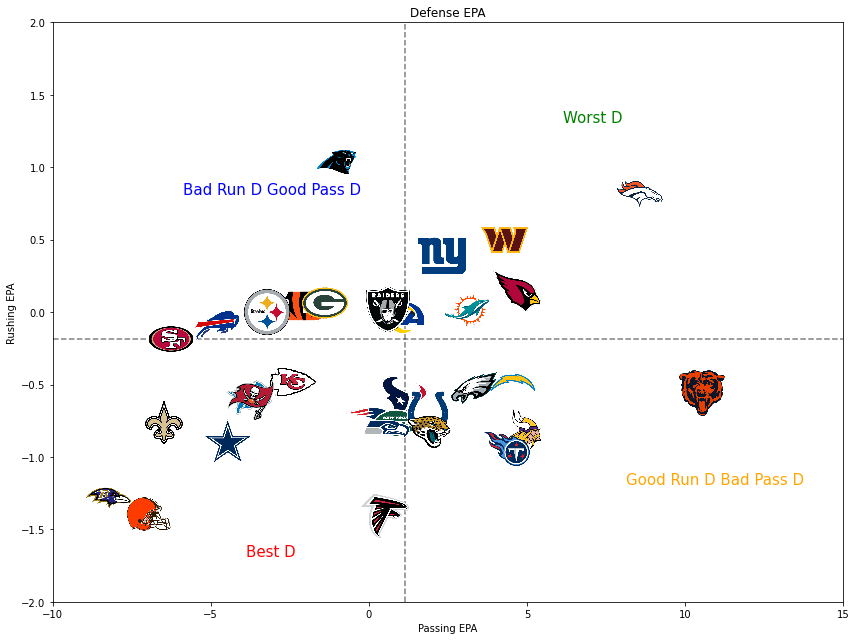

In [104]:
#chart for Defense EPA
plt.rcParams["figure.figsize"] = [12, 9]
plt.rcParams["figure.autolayout"] = True

def getImage(path):
    return OffsetImage(plt.imread(path, format="tif"), zoom=.1)

x = logos_full_df['passing_epa_defense']
y = logos_full_df['rushing_epa_defense']
paths = logos_full_df['logo_path']

fig, ax = plt.subplots()


# Define quadrant boundaries
x_mid = (x.max() + x.min()) / 2
y_mid = (y.max() + y.min()) / 2

# Quadrant 1 (Top-Right)
for x0, y0, path in zip(x, y, paths):
    if x0 >= x_mid and y0 >= y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

# Quadrant 2 (Top-Left)
for x0, y0, path in zip(x, y, paths):
    if x0 < x_mid and y0 >= y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

# Quadrant 3 (Bottom-Left)
for x0, y0, path in zip(x, y, paths):
    if x0 < x_mid and y0 < y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

# Quadrant 4 (Bottom-Right)
for x0, y0, path in zip(x, y, paths):
    if x0 >= x_mid and y0 < y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

        
plt.axvline(x_mid, color='black', linestyle='--', alpha=0.5)
plt.axhline(y_mid, color='black', linestyle='--', alpha=0.5)
plt.xlim(-10, 15)
plt.ylim(-2, 2)
# Quadrant 1 
plt.text(x_mid + 5, y_mid + 1.5, 'Worst D', fontsize=15, color='green')

# Quadrant 2 
plt.text(x_mid - 7, y_mid + 1, 'Bad Run D Good Pass D', fontsize=15, color='blue')

# Quadrant 3 
plt.text(x_mid - 5, y_mid - 1.5, 'Best D', fontsize=15, color='red')

# Quadrant 4 
plt.text(x_mid + 7, y_mid - 1, 'Good Run D Bad Pass D', fontsize=15, color='orange')


plt.title("Defense EPA")

plt.xlabel("Passing EPA")
plt.ylabel("Rushing EPA")
plt.savefig('d_epa.png') 

plt.show()

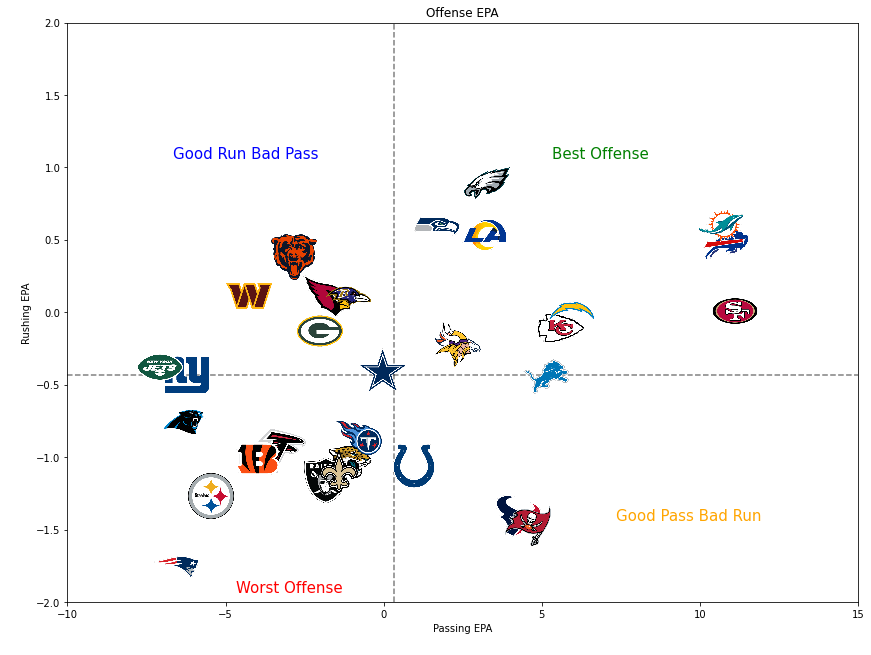

In [111]:
#chart for Defense EPA
plt.rcParams["figure.figsize"] = [12, 9]
plt.rcParams["figure.autolayout"] = True

def getImage(path):
    return OffsetImage(plt.imread(path, format="tif"), zoom=.1)

x = logos_full_df['passing_epa']
y = logos_full_df['rushing_epa']
paths = logos_full_df['logo_path']

fig, ax = plt.subplots()


# Define quadrant boundaries
x_mid = (x.max() + x.min()) / 2
y_mid = (y.max() + y.min()) / 2

# Quadrant 1 (Top-Right)
for x0, y0, path in zip(x, y, paths):
    if x0 >= x_mid and y0 >= y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

# Quadrant 2 (Top-Left)
for x0, y0, path in zip(x, y, paths):
    if x0 < x_mid and y0 >= y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

# Quadrant 3 (Bottom-Left)
for x0, y0, path in zip(x, y, paths):
    if x0 < x_mid and y0 < y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

# Quadrant 4 (Bottom-Right)
for x0, y0, path in zip(x, y, paths):
    if x0 >= x_mid and y0 < y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

        
plt.axvline(x_mid, color='black', linestyle='--', alpha=0.5)
plt.axhline(y_mid, color='black', linestyle='--', alpha=0.5)
plt.xlim(-10, 15)
plt.ylim(-2, 2)
# Quadrant 1 
plt.text(x_mid + 5, y_mid + 1.5, 'Best Offense', fontsize=15, color='green')

# Quadrant 2 
plt.text(x_mid - 7, y_mid + 1.5, 'Good Run Bad Pass', fontsize=15, color='blue')

# Quadrant 3 
plt.text(x_mid - 5, y_mid - 1.5, 'Worst Offense', fontsize=15, color='red')

# Quadrant 4 
plt.text(x_mid + 7, y_mid - 1, 'Good Pass Bad Run', fontsize=15, color='orange')


plt.title("Offense EPA")

plt.xlabel("Passing EPA")
plt.ylabel("Rushing EPA")
plt.savefig('offense_epa.png') 

plt.show()

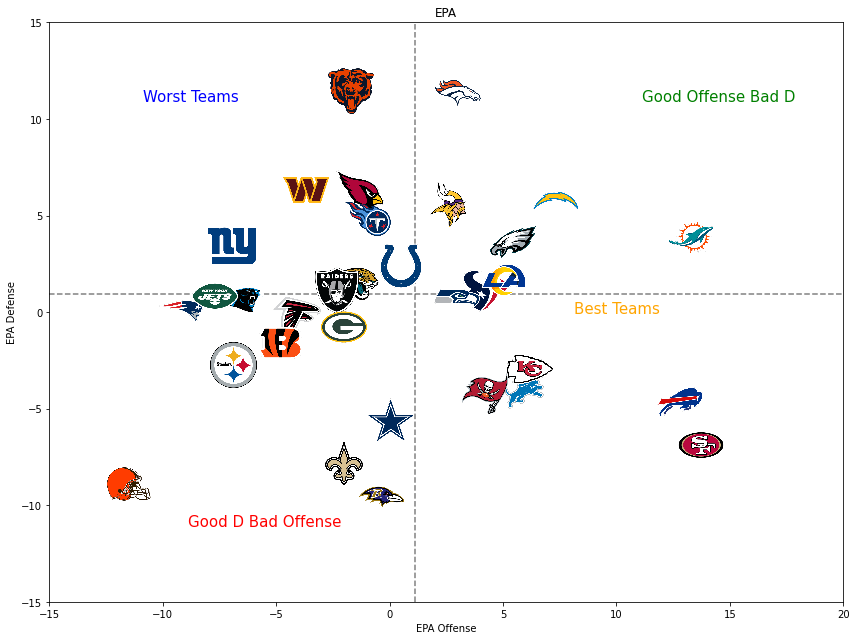

In [119]:
# chart for offense vs d epa

#chart for Defense EPA
plt.rcParams["figure.figsize"] = [12, 9]
plt.rcParams["figure.autolayout"] = True

def getImage(path):
    return OffsetImage(plt.imread(path, format="tif"), zoom=.1)

x = logos_full_df['epa_offense']
y = logos_full_df['epa_defense']
paths = logos_full_df['logo_path']

fig, ax = plt.subplots()


# Define quadrant boundaries
x_mid = (x.max() + x.min()) / 2
y_mid = (y.max() + y.min()) / 2

# Quadrant 1 (Top-Right)
for x0, y0, path in zip(x, y, paths):
    if x0 >= x_mid and y0 >= y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

# Quadrant 2 (Top-Left)
for x0, y0, path in zip(x, y, paths):
    if x0 < x_mid and y0 >= y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

# Quadrant 3 (Bottom-Left)
for x0, y0, path in zip(x, y, paths):
    if x0 < x_mid and y0 < y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

# Quadrant 4 (Bottom-Right)
for x0, y0, path in zip(x, y, paths):
    if x0 >= x_mid and y0 < y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

        
plt.axvline(x_mid, color='black', linestyle='--', alpha=0.5)
plt.axhline(y_mid, color='black', linestyle='--', alpha=0.5)
plt.xlim(-15, 20)
plt.ylim(-15, 15)
# Quadrant 1 
plt.text(x_mid + 10, y_mid + 10, 'Good Offense Bad D', fontsize=15, color='green')

# Quadrant 2 
plt.text(x_mid - 12, y_mid + 10, 'Worst Teams', fontsize=15, color='blue')

# Quadrant 3 
plt.text(x_mid - 10, y_mid - 12, 'Good D Bad Offense', fontsize=15, color='red')

# Quadrant 4 
plt.text(x_mid + 7, y_mid - 1, 'Best Teams', fontsize=15, color='orange')


plt.title("EPA")

plt.xlabel("EPA Offense")
plt.ylabel("EPA Defense")
#plt.savefig('d_epa.png') 

plt.show()